# Annotation Evaluation via Classification

Put your trained Large Language Model to use to examine how annotators and guidelines might have influenced the model performance. Specifically, you’ll perform annotator ablation tests where we hold out the annotations of some groups of annotators and see how (1) the model performance changes and (2) in the validation set, whether model predictions
are more or less similar to those annotators’ labels.

In [1]:
import os
from pathlib import Path

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns

from datasets import load_dataset, load_metric, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments, EvalPrediction
import torch
import wandb
torch.cuda.empty_cache()

In [2]:
# define ablation metrics function
def compute_ablation_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    preds = preds.reshape(len(preds),)
    mse = mean_squared_error(labels, preds)
    return {
        'mse': mse
    }

## Load Data

In [3]:
train_data = pd.read_csv('data/si630w22-hw3-train.csv')
dev_data = pd.read_csv('data/si630w22-hw3-dev.csv')
q_and_a_data = pd.read_csv('data/si630w22-hw3-data.csv')

In [4]:
q_and_a_data['text'] = q_and_a_data.question_text + '[SEP]' + q_and_a_data.reply_text

In [5]:
train_data_ablation = train_data.rename(columns={'id':'question_id', 'rating':'labels'})
train_data_ablation = pd.merge(train_data_ablation,q_and_a_data[['text','question_id']], on='question_id', how='left')
train_data_ablation.dropna(subset=['labels'], inplace = True)

dev_data_ablation = dev_data.rename(columns={'id':'question_id', 'rating':'labels'})
dev_data_ablation = pd.merge(dev_data_ablation,q_and_a_data[['text','question_id']], on='question_id', how='left')
dev_data_ablation.dropna(subset=['labels'], inplace = True)

## Initialize Ablation Directories

In [6]:
# all groups
all_groups = train_data_ablation.group.unique()

# make ablation_data dirs for all groups
ablation_data_dir = Path('./ablation_data/') 
if ablation_data_dir.exists() == False:
    print("Creating Ablation Data Directory")
    os.mkdir(ablation_data_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_data_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Data Directory Already Exists")
    
# make ablation_training dirs for all groups
ablation_training_dir = Path('./ablation_training/') 
if ablation_training_dir.exists() == False:
    print("Creating Ablation Training Directory")
    os.mkdir(ablation_training_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_training_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Training Directory Already Exists")

# make ablation_model_save dirs for all groups
ablation_model_dir = Path('./ablation_model/') 
if ablation_model_dir.exists() == False:
    print("Creating Ablation Saved Model Directory")
    os.mkdir(ablation_model_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_model_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Saved Model Directory Already Exists")

# make ablation_prediction dirs for all groups
ablation_predict_dir = Path('./ablation_prediction/') 
if ablation_predict_dir.exists() == False:
    print("Creating Ablation Prediction Directory")
    os.mkdir(ablation_predict_dir)
    for group_name in all_groups:
        group_dir = group_name
        group_path = os.path.join(ablation_predict_dir, group_dir)
        os.mkdir(group_path)
else:
    print("Ablation Prediction Directory Already Exists")

Ablation Data Directory Already Exists
Ablation Training Directory Already Exists
Ablation Saved Model Directory Already Exists
Ablation Prediction Directory Already Exists


## Initial Debugging Pass

Complete Ablation Test Method only on Group 1. Then generalize code to loop through all groups to perform ablation tests.

After initial debugging pass was completed without error on `group_01`, the code was copied into a loop and tested on the first three groups in `all_groups`. Then, once this ran without error, the loop was applied to every group in `all_groups`.

The method is outlined below, but debugging code was removed.
1. Create Group Specific Paths
2. Create Train Data
3. Create Test Data
    - Training
        1. remove any question_ids annotated by group 1. This is the first training set
        2. group by remaining question_ids (after group 1 ids were removed) and average the rating value - this is the ground truth for training
        3. apply the rating value to the question_ids in the training set
    - Dev Split A
        1. repeat the process used for the training set ground truth labels
    - Dev Split B
        1. using only group 1 question_ids, average the rating value of group 1 annotators on these question_ids - this is the ground truth for dev split b
        2. apply the rating value to the question_ids in the dev split b set
    - Dev Split C
        1. using only group 1 question_ids, average the rating value of all other groups (excluding group 1) on these question_ids - this is the ground truth for dev split c
        2. apply the rating value to the question_ids in the dev split c set
    - Repeat this process for every single group
        - There will be 3 separate ground truth labels for each of the Dev splits. We then evaluate each dev split (for every group) and calcualate correlation for every group and plot.
4. Data Preprocessing
    - Data Loading
    - Data Tokenizing
    - Data Formatting
5. Intialize and Train Model
6. Make Predictions
7. Calculate Correlations

In [12]:
print('FORMATTING DATA')

tokenized_ablation_train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
tokenized_ablation_test_dataset_a.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
tokenized_ablation_test_dataset_b.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
tokenized_ablation_test_dataset_c.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])

FORMATTING DATA


## Complete Ablation Tests

Loop through all groups (23 in total) and complete the ablation test method

In [58]:
# same tokenizer for every group
tokenizer = BertTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased", padding = True, truncation=True ,max_length =512)

# same model and training args for every training.
helpfulness_model = BertForSequenceClassification.from_pretrained("simple_best_model/", num_labels=1)

loading file https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/resolve/main/vocab.txt from cache at /home/sryanlee/.cache/huggingface/transformers/49c302ee103bf6737d0877cfbd658563cf4bbc4b7914363ca419ce8a3d8a4c51.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/resolve/main/special_tokens_map.json from cache at /home/sryanlee/.cache/huggingface/transformers/1e5909e4dfaa904617797ed35a6105a23daa56cbefca48fef329f772584699fb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/resolve/main/tokenizer_config.json from cache at /home/sryanlee/.cache/huggingface/transformers/29039dfe8c131360348e9f5ebecd464478cec7576c9af532b55ddcf9d4ec8d1e.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
lo

In [60]:
all_correlations = []
for group_name in all_groups:
    
    # create group specific paths
    group_data_path = os.path.join(ablation_data_dir, group_name)
    group_training_path = os.path.join(ablation_training_dir, group_name)
    group_model_path = os.path.join(ablation_model_dir, group_name)
    group_predict_path = os.path.join(ablation_predict_dir, group_name)

    print('STARTING ABLATION:', group_name.upper())
    
    # remove all annotations by any annotator in g1 from training data
    print('CREATING TRAIN DATA')

    g_annotators = train_data_ablation[train_data_ablation['group'] == group_name].annotator_id.unique()
    g_drop_index = train_data_ablation[train_data_ablation['annotator_id'].isin(g_annotators)].index
    g_drop_data = train_data_ablation.drop(g_drop_index)

    # create ground truth by averaging scores of remaining annotators
    g_truth = g_drop_data.groupby('question_id').mean()
    g_drop_data_truth = g_drop_data.merge(g_truth, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_drop_data_truth.to_csv(os.path.join(group_data_path, group_name+'_train.csv'), index=False)
    
    # split dev data into 3 test sets 
    print('CREATING TEST DATA')
    g_qdev_index = dev_data_ablation[dev_data_ablation['annotator_id'].isin(g_annotators)].index

    # replies without any annotators in g
    g_dev_a = dev_data_ablation.drop(g_qdev_index)
    g_truth_a = g_dev_a.groupby('question_id').mean()
    g_dev_a_truth = g_dev_a.merge(g_truth_a, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_dev_a_truth.to_csv(os.path.join(group_data_path, group_name+'_dev_a.csv'), index=False)

    # replies to items with annotators in g1 and using their annotations
    g_dev_b = dev_data_ablation.loc[g_qdev_index]
    g_truth_b = g_dev_b.groupby('question_id').mean()
    g_dev_b_truth = g_dev_b.merge(g_truth_b, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_dev_b_truth.to_csv(os.path.join(group_data_path, group_name+'_dev_b.csv'), index=False)

    # the same replies as b but using the annotations by the individuals not in g1
    g_qids = g_dev_b.question_id.unique()
    g_dev_c = g_dev_a[g_dev_a['question_id'].isin(g_qids)].copy()
    g_truth_c = g_dev_c.groupby('question_id').mean()
    g_dev_c_truth = g_dev_c.merge(g_truth_c, on='question_id', how='left').drop(columns='labels_x').rename(columns={'labels_y':'labels'}).drop_duplicates(subset='question_id')
    g_dev_c_truth.to_csv(os.path.join(group_data_path, group_name+'_dev_c.csv'), index=False)
    
    # data preprocessing - data loading
    print('LOADING DATA')
    ablation_train_dataset = load_dataset("csv", data_files={"train": os.path.join(group_data_path, group_name+'_train.csv')})
    ablation_test_dataset_a = load_dataset('csv', data_files={"test": os.path.join(group_data_path, group_name+'_dev_a.csv')})
    ablation_test_dataset_b = load_dataset('csv', data_files={"test": os.path.join(group_data_path, group_name+'_dev_b.csv')})
    ablation_test_dataset_c = load_dataset('csv', data_files={"test": os.path.join(group_data_path, group_name+'_dev_c.csv')})
    
    # data preprocessing - tokenization
    print('TOKENIZING DATA')
    tokenized_ablation_train_dataset = ablation_train_dataset['train'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    tokenized_ablation_test_dataset_a = ablation_test_dataset_a['test'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    tokenized_ablation_test_dataset_b = ablation_test_dataset_b['test'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    tokenized_ablation_test_dataset_c = ablation_test_dataset_c['test'].map(lambda x: tokenizer(x['text'],padding = 'max_length', max_length =512, truncation=True))
    
    # data preprocessing - formatting
    print('FORMATTING DATA')

    tokenized_ablation_train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    tokenized_ablation_test_dataset_a.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    tokenized_ablation_test_dataset_b.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    tokenized_ablation_test_dataset_c.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask','labels'])
    
    # initialize TrainingArguments, Trainer classes, model (simple_best_model) defined globally
    print('INITIALIZING MODEL')

    group_output_dir = os.path.join(group_training_path, group_name+'_model/')
    
    ablation_training_args = TrainingArguments(
        output_dir = group_output_dir, 
        num_train_epochs = 3,
        eval_steps = 500,
        learning_rate=1e-4,
        per_device_train_batch_size = 8,
        per_device_eval_batch_size = 8,
        seed = 0,
    )
    
    ablation_trainer = Trainer(
        helpfulness_model,
        ablation_training_args,
        train_dataset=tokenized_ablation_train_dataset,
        compute_metrics=compute_ablation_metrics,
    )
    
    # train the model on the ablation group
    print('TRAINING MODEL')
    ablation_trainer.train()
    ablation_trainer.save_model(os.path.join(group_model_path, group_name+'_trained_model'))
    
    # use 3 dev sets as test sets and evaluate them all separately
    print('MAKING PREDICTIONS')

    outputs_a = ablation_trainer.predict(tokenized_ablation_test_dataset_a)
    y_pred_a = outputs_a.predictions
    g_dev_a_truth['predicted'] = y_pred_a
    g_dev_a_truth['ablation_group'] = group_name
    g_dev_a_truth['subset'] = 'a'
    g_dev_a_truth['mse'] = mean_squared_error(g_dev_a_truth.labels, g_dev_a_truth.predicted)

    outputs_b = ablation_trainer.predict(tokenized_ablation_test_dataset_b)
    y_pred_b = outputs_b.predictions
    g_dev_b_truth['predicted'] = y_pred_b
    g_dev_b_truth['ablation_group'] = group_name
    g_dev_b_truth['subset'] = 'b'
    g_dev_b_truth['mse'] = mean_squared_error(g_dev_b_truth.labels, g_dev_b_truth.predicted)

    outputs_c = ablation_trainer.predict(tokenized_ablation_test_dataset_c)
    y_pred_c = outputs_c.predictions
    g_dev_c_truth['predicted'] = y_pred_c
    g_dev_c_truth['ablation_group'] = group_name
    g_dev_c_truth['subset'] = 'c'
    g_dev_c_truth['mse'] = mean_squared_error(g_dev_c_truth.labels, g_dev_c_truth.predicted)
    
    # combine predictions
    group_predictions = pd.concat([g_dev_a_truth, g_dev_b_truth, g_dev_c_truth], axis=0)
    group_predictions.to_csv(os.path.join(group_predict_path, group_name+'_predictions_combined.csv'), index=False)
    
    # calculate correlation
    group_correlations = group_predictions.drop(['question_id','annotator_id', 'group', 'mse'], axis=1).groupby(['ablation_group', 'subset']).corr()
    group_correlations_long = group_correlations.drop('labels', axis=1).reset_index().drop('level_2', axis=1).drop_duplicates(subset='subset').rename(columns={'predicted':'correlation'})
    all_correlations.append(group_correlations_long)

STARTING ABLATION: GROUP_09
GROUP DATA PATH: ablation_data/group_09
GROUP TRAINING PATH: ablation_training/group_09
GROUP MODEL PATH: ablation_model/group_09
GROUP PREDICT PATH: ablation_prediction/group_09
CREATING TRAIN DATA
group annotators
 ['user_00' 'user_01' 'user_02'] 

Success: Row Drop Match
Number of Rows Dropped:  921
CREATING TEST DATA
Unique Question IDs Mismatch
number of unique questions gi annotated: 61
number of unique questions annotated by other groups: 59
LOADING DATA


Using custom data configuration default-2f945a000c4c02c1


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-2f945a000c4c02c1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-0d8b4fe71d7efd54


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-0d8b4fe71d7efd54/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-c8cc3e03efdbbb9d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-c8cc3e03efdbbb9d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-299212abaf51852c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-299212abaf51852c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3768 [00:00<?, ?ex/s]

  0%|          | 0/809 [00:00<?, ?ex/s]

  0%|          | 0/61 [00:00<?, ?ex/s]

  0%|          | 0/59 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3768
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.522300
1000,0.471300


Saving model checkpoint to ablation_training/group_09/group_09_model/checkpoint-500
Configuration saved in ablation_training/group_09/group_09_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_09/group_09_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_09/group_09_model/checkpoint-1000
Configuration saved in ablation_training/group_09/group_09_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_09/group_09_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_09/group_09_trained_model
Configuration saved in ablation_model/group_09/group_09_trained_model/config.json
Model weights saved in ablation_model/group_09/group_09_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 59
  Batch size = 8


STARTING ABLATION: GROUP_03
GROUP DATA PATH: ablation_data/group_03
GROUP TRAINING PATH: ablation_training/group_03
GROUP MODEL PATH: ablation_model/group_03
GROUP PREDICT PATH: ablation_prediction/group_03
CREATING TRAIN DATA
group annotators
 ['user_03' 'user_04'] 

Success: Row Drop Match
Number of Rows Dropped:  620
CREATING TEST DATA
Unique Question IDs Mismatch
number of unique questions gi annotated: 62
number of unique questions annotated by other groups: 58
LOADING DATA


Using custom data configuration default-83b59bbc8b86e7f2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-83b59bbc8b86e7f2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-177bb2d08c860fca


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-177bb2d08c860fca/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f39aff3b7e7ccf5b


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-f39aff3b7e7ccf5b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7ddc81fe127d270a


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-7ddc81fe127d270a/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3766 [00:00<?, ?ex/s]

  0%|          | 0/807 [00:00<?, ?ex/s]

  0%|          | 0/62 [00:00<?, ?ex/s]

  0%|          | 0/58 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3766
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.542100
1000,0.451800


Saving model checkpoint to ablation_training/group_03/group_03_model/checkpoint-500
Configuration saved in ablation_training/group_03/group_03_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_03/group_03_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_03/group_03_model/checkpoint-1000
Configuration saved in ablation_training/group_03/group_03_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_03/group_03_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_03/group_03_trained_model
Configuration saved in ablation_model/group_03/group_03_trained_model/config.json
Model weights saved in ablation_model/group_03/group_03_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 62
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 58
  Batch size = 8


STARTING ABLATION: GROUP_10
GROUP DATA PATH: ablation_data/group_10
GROUP TRAINING PATH: ablation_training/group_10
GROUP MODEL PATH: ablation_model/group_10
GROUP PREDICT PATH: ablation_prediction/group_10
CREATING TRAIN DATA
group annotators
 ['user_05' 'user_06' 'user_07'] 

Success: Row Drop Match
Number of Rows Dropped:  906
CREATING TEST DATA
Unique Question IDs Mismatch
number of unique questions gi annotated: 53
number of unique questions annotated by other groups: 52
LOADING DATA


Using custom data configuration default-6fcf357bb469f29e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-6fcf357bb469f29e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-a4a781ad0c424ba0


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-a4a781ad0c424ba0/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-c42f67616911e07f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-c42f67616911e07f/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-1d295a8648d5bca2


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sryanlee/.cache/huggingface/datasets/csv/default-1d295a8648d5bca2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

TOKENIZING DATA


  0%|          | 0/3764 [00:00<?, ?ex/s]

  0%|          | 0/810 [00:00<?, ?ex/s]

  0%|          | 0/53 [00:00<?, ?ex/s]

  0%|          | 0/52 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sryanlee/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3764
  Num Epo

FORMATTING DATA
INITIALIZING MODEL
TRAINING MODEL


Step,Training Loss
500,0.545500
1000,0.426200


Saving model checkpoint to ablation_training/group_10/group_10_model/checkpoint-500
Configuration saved in ablation_training/group_10/group_10_model/checkpoint-500/config.json
Model weights saved in ablation_training/group_10/group_10_model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ablation_training/group_10/group_10_model/checkpoint-1000
Configuration saved in ablation_training/group_10/group_10_model/checkpoint-1000/config.json
Model weights saved in ablation_training/group_10/group_10_model/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ablation_model/group_10/group_10_trained_model
Configuration saved in ablation_model/group_10/group_10_trained_model/config.json
Model weights saved in ablation_model/group_10/group_10_trained_model/pytorch_model.bin
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` a

MAKING PREDICTIONS


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 53
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, question_id, annotator_id, group. If text, question_id, annotator_id, group are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 52
  Batch size = 8


## Combine Ablation Results

Pull predictions from every ablation group. Combine into one dataframe with new field `ablation group`. Calculate correlations and plot into a bar graph where each group has a set of 3 bars, one for each dev split.

<AxesSubplot:xlabel='ablation_group', ylabel='correlation'>

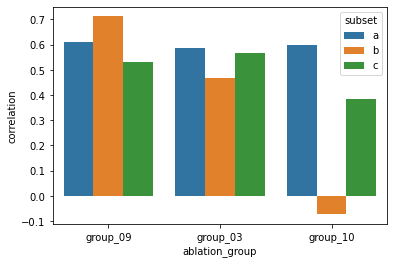

In [61]:
# concat all correlations and then plot
all_correlations_df = pd.concat(all_correlations, axis=0)
sns.barplot(data=all_correlations_df, x='ablation_group', y='correlation', hue='subset')